## Wikipedia Time Series Analysis
1. Data exploration
2. Model tuning
3. Modeling evaluation and selection
4. Forecasting
5. Conclusion

In [87]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import seaborn as sns
import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
from pmdarima.metrics import smape

from tqdm import tqdm
import warnings
#ignore the warnings about not having different language fonts available 
warnings.filterwarnings(action='ignore') 

import logging
logger = logging.getLogger('ftpuploader')

### Data Exploration and Processing

In [2]:
#load data and downcast to integers
orig_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_1.csv')
key = pd.read_csv('/Users/christinejiang/Documents/Python/data/key_1.csv')
submission = pd.read_csv('/Users/christinejiang/Documents/Python/data/sample_submission_1.csv')
train = orig_train.fillna(0)
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col], downcast = 'integer')

In [3]:
def find_lang(page):
    match = re.search('[a-z][a-z].wikipedia.org', page)
    if match:
        return match.group(0)[0:2]
    return 'na'

def find_article(page):
    match = re.search('[a-z][a-z].wikipedia.org.', page)
    if match:
        article_end = match.start()-1
        return(page[0:article_end])
    return 'na'

def find_access(page):
    match = re.search('.*.wikipedia.org.', page)
    if match:
        access_start = match.end()
        return(page[access_start:])
    return 'na'

train['Language'] = train['Page'].map(find_lang)
train['Article'] = train['Page'].map(find_article)
train['Access'] = train['Page'].map(find_access)

In [4]:
dates = train.iloc[:,1:551]
labels = train[['Article','Language','Access','Page']]
newtrain = pd.concat([labels, dates], axis = 1)

display(newtrain.head(2))
#newtrain['Total'] = newtrain.sum(axis=1)
newtrain['Language'].value_counts().sort_values(ascending=False)

,Article,Language,Access,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access_spider,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,...,32,63,15,26,14,20,22,19,18,20
1,2PM,zh,all-access_spider,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,...,17,42,28,15,9,30,52,45,26,20


en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: Language, dtype: int64

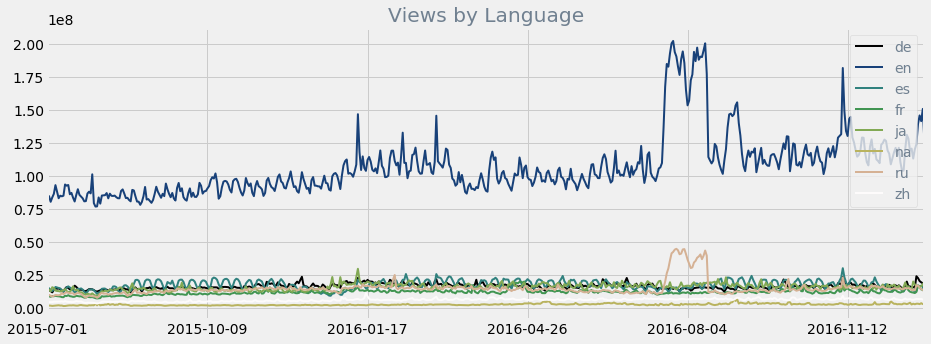

In [5]:
#plot the total views per language
def plot_groups(df, groupby):
    plt.style.use('fivethirtyeight')
    group = df.groupby(groupby).sum().reset_index()
    transpose = group.T
    transpose = transpose.rename(columns = transpose.iloc[0]).drop(transpose.index[0])
    figure = transpose.plot(figsize=(14,5), use_index = True, colormap = "gist_earth", lw=2)
    title=plt.title('Views by '+str(groupby), color='slategray')
    plt.legend(loc='upper left')
    plt.setp(plt.legend().get_texts(), color='slategray')
    return transpose

transposed = plot_groups(newtrain.iloc[:,:-1], 'Language')

In [6]:
#get random indices to plot
languages = newtrain['Language'].unique()
indices = np.random.randint(1,1400,size=3)
num_results = len(indices)
print(indices)

[134 740 878]


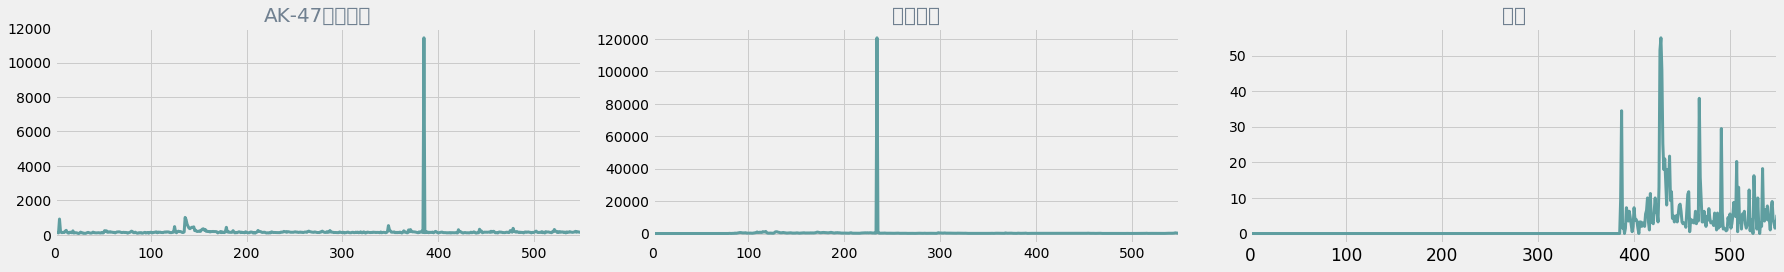

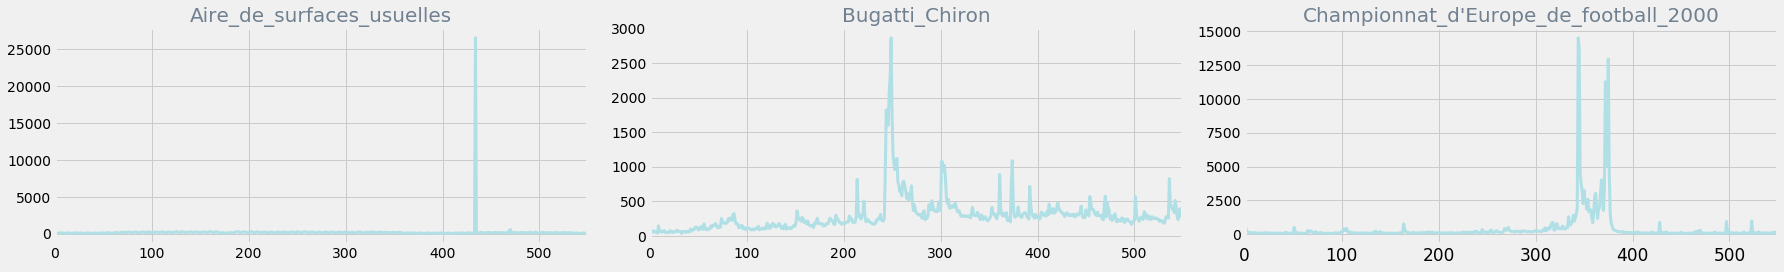

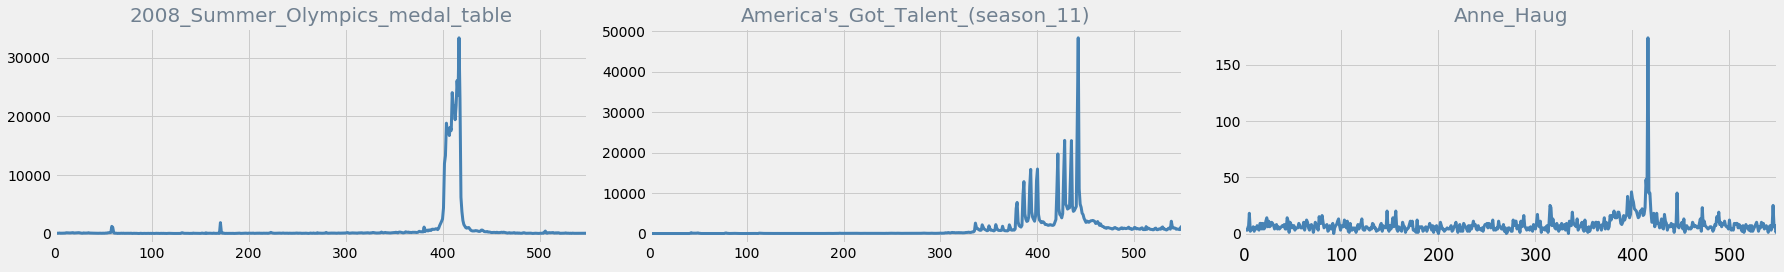

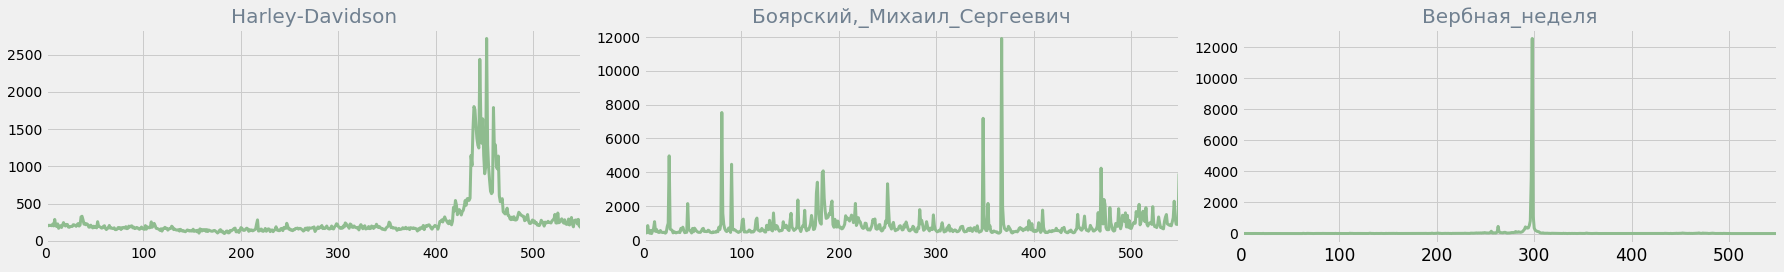

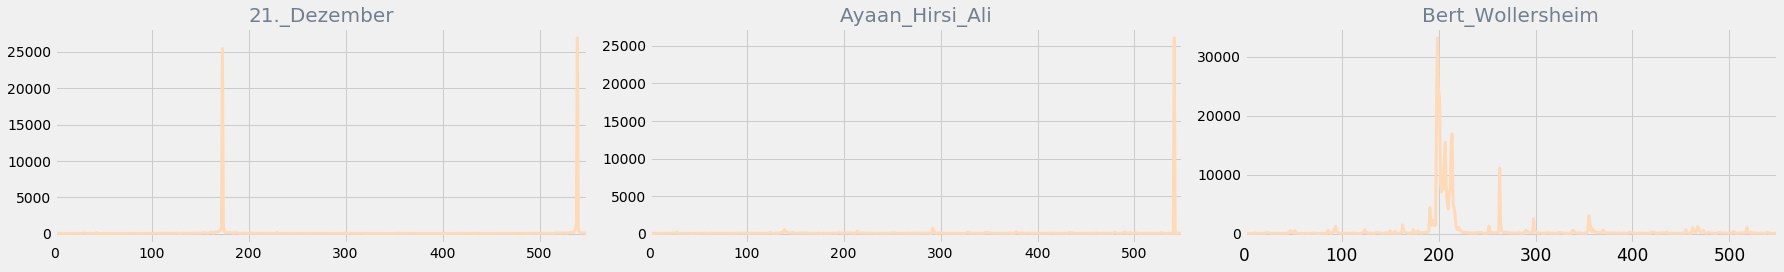

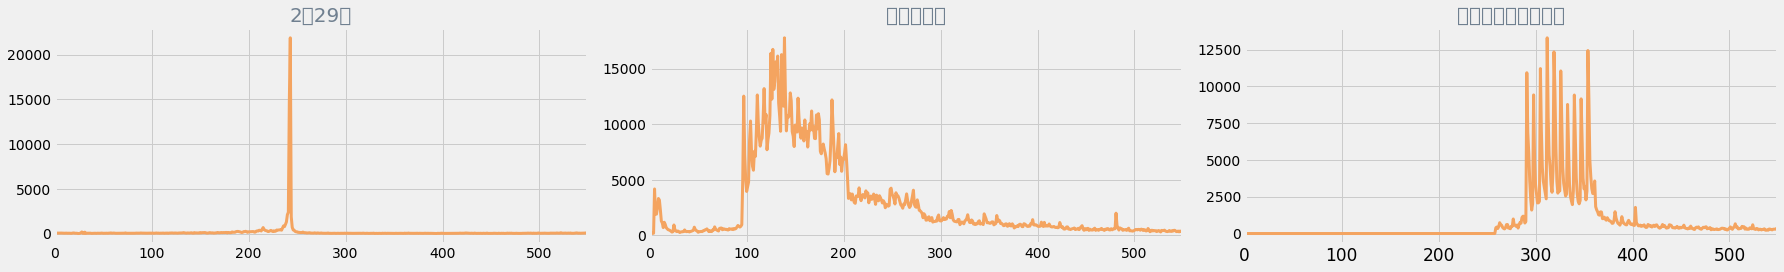

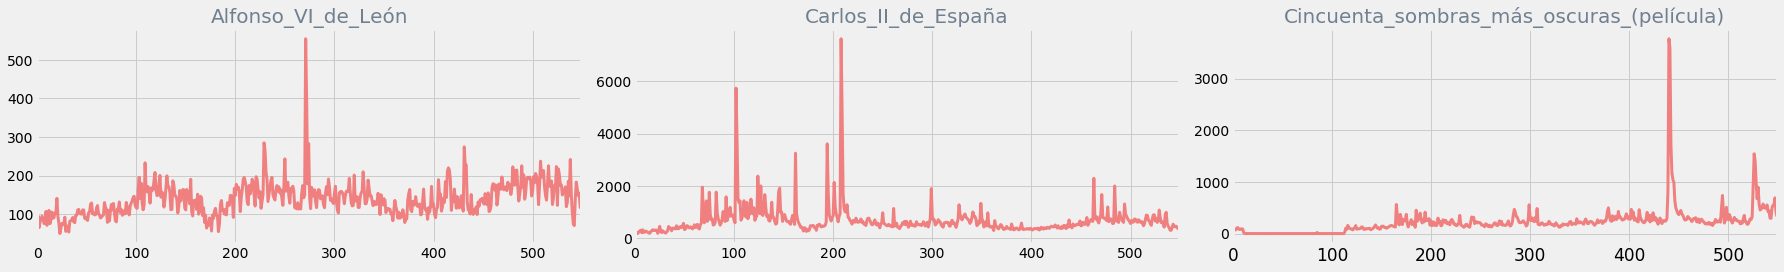

In [7]:
#plot a sample of pages for each language
colors = ['cadetblue','powderblue','steelblue','yellowgreen','darkseagreen','peachpuff','sandybrown','lightcoral']
dataframedict = {}
for i,language in enumerate(languages):
    dataframedict[language] = newtrain[newtrain['Language']==language]
    if language != 'na':
        langcolor = colors[i]
        fig, subaxes = plt.subplots(1,num_results,figsize=[25,4])
        pivottable = dataframedict[language].pivot_table(columns='Article')
        for i, index in enumerate(indices):
            singlerecord = pivottable.iloc[:,index]
            plt.xticks(fontsize=17)
            sns.tsplot(singlerecord,ax = subaxes[i],color=langcolor, linewidth=3)
            subaxes[i].set_title(singlerecord.name, color='slategray')
            subaxes[i].title.set_size(20)
            #fig.suptitle(language)
            plt.tight_layout()
    dataframedict[language]['Total'] = dataframedict[language].sum(axis=1)


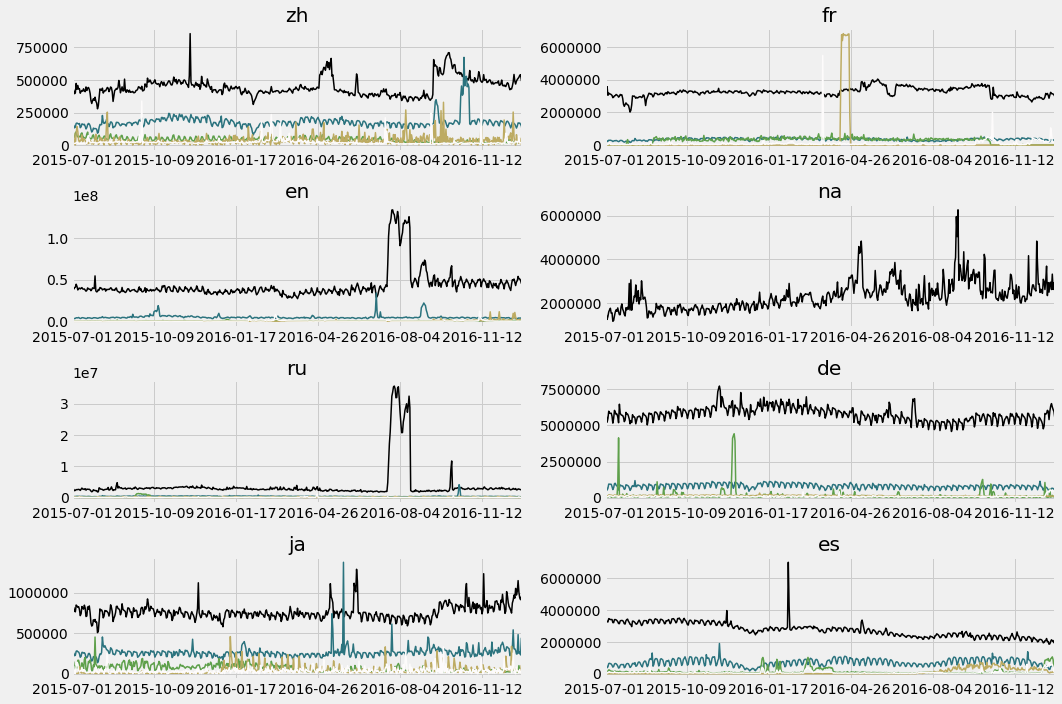

In [8]:
#plot top 5 pages for every language
fig, subaxes = plt.subplots(4,2,figsize=(15,10))
subaxes = subaxes.flatten()
x = [[a,b] for a in range(0,4) for b in range(0,2)]
for i,language in enumerate(languages):
    total_hits = dataframedict[language].groupby('Article').sum()
    top5sites = total_hits.nlargest(5, 'Total')
    axis = subaxes[x[i]]
    top5sites.T.iloc[:-1].plot(lw=1.5, ax=subaxes[i], colormap = 'gist_earth')
    subaxes[i].get_legend().remove()
    subaxes[i].set_title(language)
plt.tight_layout()

### Time Series Modeling

In [150]:
class TimeSeries:
    def __init__(self, ts):
        self.ts = ts
        self.df = pd.DataFrame(ts).rename(columns={0:'Hits'})
        self.adf_statistic = self.stationarity_check()[0]
        self.pvalue = self.stationarity_check()[1]
        self.stationary = self.stationarity_check()[2]
        
    def stationarity_check(self):
        ts = self.ts
        stationarity = adfuller(ts)
        adf_statistic = stationarity[0]
        pvalue = stationarity[1]
        if stationarity[0] < stationarity[4]['5%']:
            stationary = True
        else:
            stationary = False
        return adf_statistic, pvalue, stationary
            
    def plot_diffs(self):
        plt.style.use('fivethirtyeight')
        ts = self.ts
        fig, axes = plt.subplots(3,3,figsize=(18,10))
        axes = axes.reshape(9,)
        for i in range(0,3):
            if i == 0:
                ts.plot(ax=axes[0], lw=2)
                plot_acf(ts, ax=axes[1])
                plot_pacf(ts, ax=axes[2])
                axes[0].set_title('Original Series')
            if i > 0:
                lag = ts.diff(i)
                axis_start = i**2+2
                lag.plot(ax=axes[axis_start], lw=2)
                plot_acf(lag[i:], ax=axes[axis_start+1])
                plot_pacf(lag[i:], ax=axes[axis_start+2])
                axes[axis_start].set_title('Lag of '+str(i))
            plt.tight_layout()
            
    def plot_rolling(self, n=12):
        ts = self.ts
        fig, axes = plt.subplots(1,figsize=(10,4))
        ts.rolling(n).std().plot(color='darkseagreen', ax=axes, lw=2)
        ts.plot(ax=axes, color='lightcoral', lw=2)
        ts.rolling(n).mean().plot(ax=axes, lw=2)
        plt.title('Time Series with Rolling Statistics')
        legend = axes.legend(['Rolling Std.','Original','Rolling Avg.'])
        
    def decompose(self, zoom=True):
        ts = self.ts
        #plt.style.use('seaborn')
        mul_result = seasonal_decompose(ts, model = 'multiplicative', period=7)
        plt.rcParams['figure.figsize'] = (10,4)
        fig = mul_result.plot().suptitle('Multiplicative')
        add_result = seasonal_decompose(ts, model = 'additive', period=7)
        #fig2 = add_result.plot().suptitle('Additive')
        if zoom:
            df = mul_result.seasonal.to_frame()
            df['day'] = df.index.day_name()
            df.index = df['day']
            df.drop('day',axis=1,inplace=True)
            fig = df[0:15].plot(kind='bar', figsize=(11,3), color='darkseagreen') 
            plt.title('Seasonal Trend')
            fig.get_legend().remove()
        return mul_result, add_result
            
    def auto_arima(self):
        ts = self.ts
        train, test = train_test_split(ts, test_size = 0.25)

        autoarima = pm.auto_arima(train, start_p=0, start_q=0, d=None, max_p=3, max_q=3, max_order=5,
                    m=7, seasonal=True, stepwise = True)

        train.plot(lw=3, label='actual train')
        test.plot(lw=3, label= 'actual test', color='yellowgreen')
        predictions, confint = autoarima.predict(test.shape[0], return_conf_int=True)

        predictions_series = pd.Series(predictions, index = test.index)
        predictions_series.plot(lw=3, color='orangered', label='predictions')
        fitted_series = pd.Series(autoarima.predict_in_sample(start=0, end=train.shape[0]-1), index = train.index)
        fitted_series.plot(lw=3, color='orangered', label='fitted')
        lower_series = pd.Series(confint[:, 0], index=test.index)
        upper_series = pd.Series(confint[:, 1], index=test.index)
        plt.fill_between(lower_series.index, lower_series, upper_series, color='gray',alpha=0.25)
        plt.legend(loc='upper left')
        
        display(autoarima.summary())
        fig = autoarima.plot_diagnostics(figsize=(10,6))
        plt.tight_layout()
    
        squared_error = mean_squared_error(test, predictions_series)
        mean_error = np.sqrt(squared_error)
        percent_error = mean_error/ts.mean()
        smape_value = smape(test, predictions_series)
        print(f'''
        mean error: {mean_error}
        percent_error: {percent_error}
        smape: {smape_value}''')
        return mean_error, percent_error, smape_value

In [160]:
#function to make a dataframe for any article
def make_df(article):
    totals = newtrain[newtrain['Article']==article].sum()
    rows = totals[4:-1].astype(float)
    rows.index = pd.DatetimeIndex(rows.index)
    return rows

#create timeseries object
#myseries = make_df('Bill_Nye')
timeseries = TimeSeries(myseries)

adf: -8.501197569593439, 
p-value: 1.2369797715198903e-13,
stationary: True


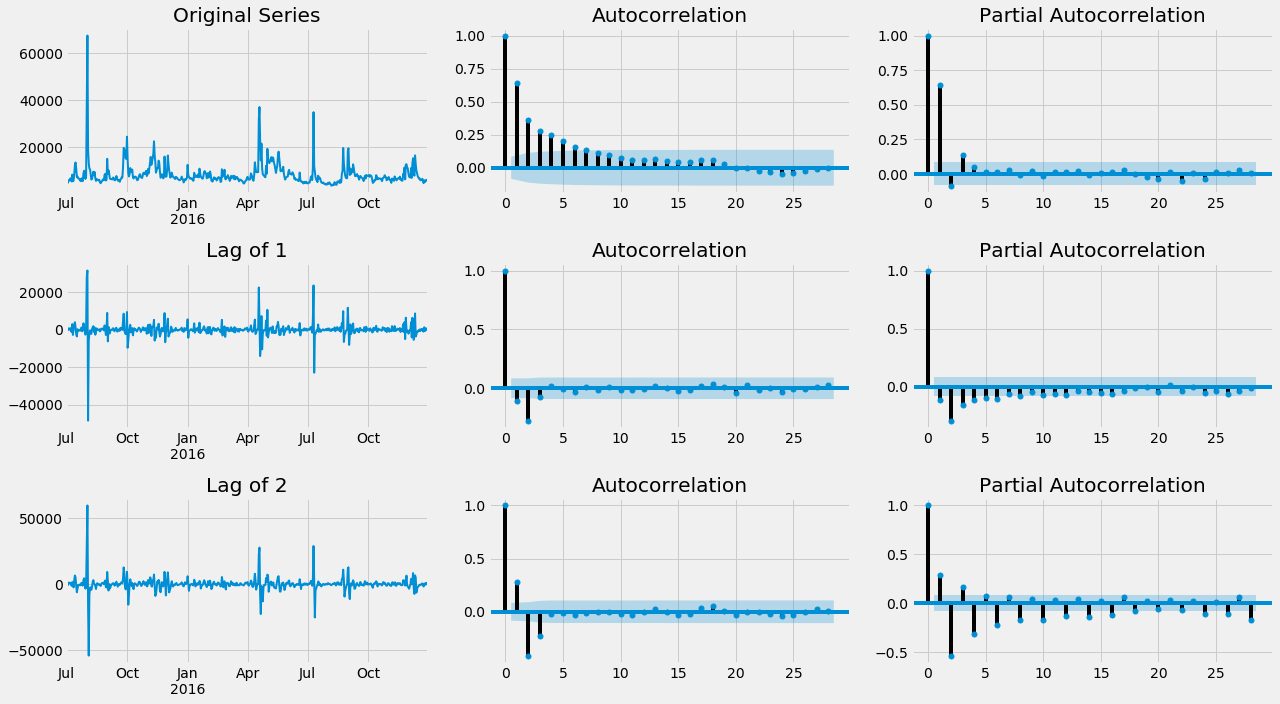

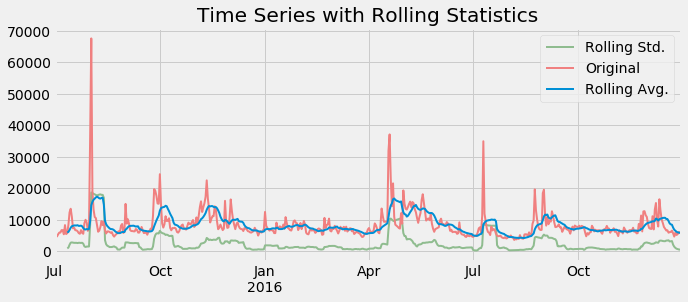

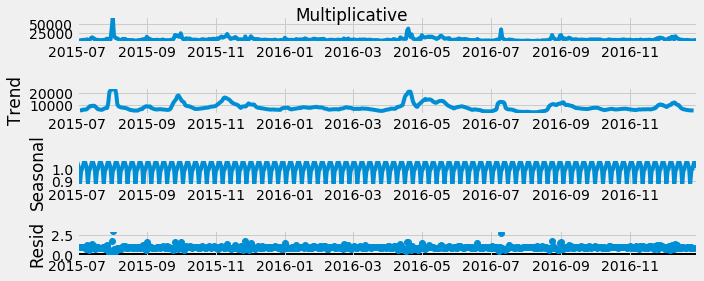

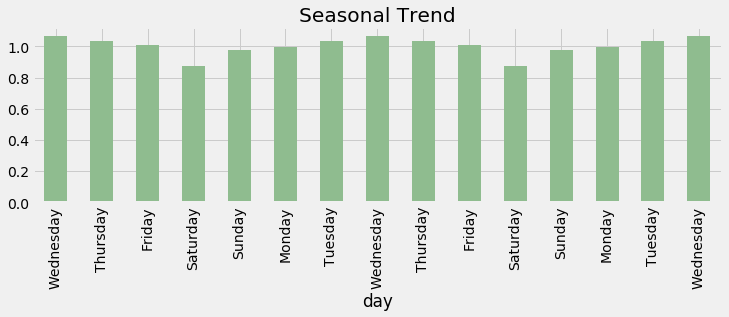

In [161]:
#call each method on the object
adf_statistic, pvalue, stationary = timeseries.stationarity_check()
print(f'''adf: {adf_statistic:}, 
p-value: {pvalue},
stationary: {stationary}''')

timeseries.plot_diffs()
timeseries.plot_rolling()
mul, add = timeseries.decompose()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  411
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -3981.683
Date:                Tue, 03 Mar 2020   AIC                           7973.366
Time:                        14:03:21   BIC                           7993.459
Sample:                             0   HQIC                          7981.315
                                - 411                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2893.2803    432.961      6.683      0.000    2044.692    3741.868
ar.L1          0.7115      0.016     44.955      0.000       0.681       0.743
ar.L2         -0.1948      0.032     -6.173      0.000      -0.257      -0.133
ar.L3          0.1440      0.031      4.628      0.000       0.083       0.205
sigma2      1.528e+07      0.398   3.84e+07      0.000    1.53e+07    1.53e+07
===================================================================================
Ljung-Box (Q):                       13.25   Jarque-Bera (JB):             30823.67
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             3.91
Prob(H) (two-sided):                  0.00   Kurtosis:                        44.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.52e+22. Standard errors may be unstable.
"""


        mean error: 2769.0766532425932
        percent_error: 0.3309393493981454
        smape: 25.567551598349706


(2769.0766532425932, 0.3309393493981454, 25.567551598349706)

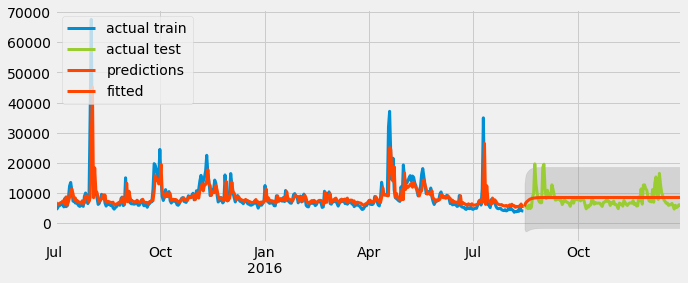

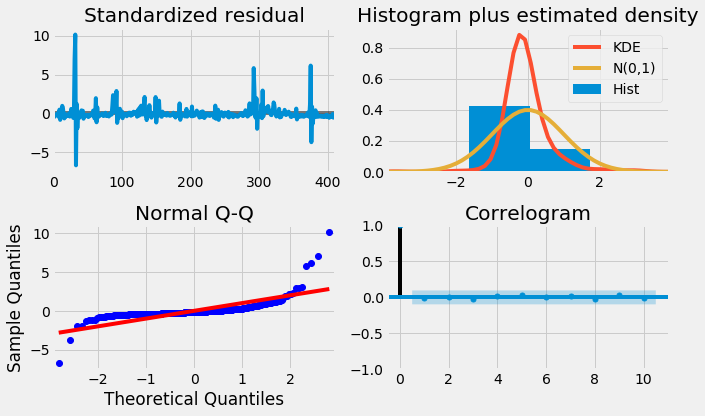

In [162]:
timeseries.auto_arima()

In [15]:
#things to understand:
#aic
#smape
#ar vs ma process
#svg did not converge
#seasonal?

In [192]:
key

,Page,Id
0,!vote_en.wikipedia.org_all-access_all-agents_2...,bf4edcf969af
1,!vote_en.wikipedia.org_all-access_all-agents_2...,929ed2bf52b9
2,!vote_en.wikipedia.org_all-access_all-agents_2...,ff29d0f51d5c
3,!vote_en.wikipedia.org_all-access_all-agents_2...,e98873359be6
4,!vote_en.wikipedia.org_all-access_all-agents_2...,fa012434263a
...,...,...
8703775,龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...,f69747f5ee68
8703776,龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...,2489963dc503
8703777,龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...,b0624c909f4c
8703778,龙生九子_zh.wikipedia.org_mobile-web_all-agents_20...,24a1dfb06c10


In [193]:
submission

,Id,Visits
0,bf4edcf969af,0
1,929ed2bf52b9,0
2,ff29d0f51d5c,0
3,e98873359be6,0
4,fa012434263a,0
...,...,...
8703775,f69747f5ee68,0
8703776,2489963dc503,0
8703777,b0624c909f4c,0
8703778,24a1dfb06c10,0


In [ ]:
#predict the values for all 145603 pages for dates 2017-01-01 to 2017-03-01